<a href="https://colab.research.google.com/github/ANTRIKSH-GANJOO/pytorch_research/blob/main/WithReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 26865667.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

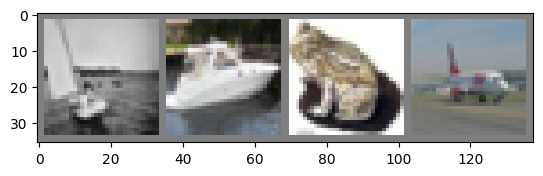

ship  ship  frog  plane


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ResidualBlock(nn.Module):
#     def __init__(self, inchannel, outchannel, stride=1):
#         super(ResidualBlock, self).__init__()
#         self.left = nn.Sequential(
#             nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
#             nn.BatchNorm2d(outchannel),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(outchannel)
#         )
#         self.shortcut = nn.Sequential()
#         if stride != 1 or inchannel != outchannel:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(outchannel)
#             )

#     def forward(self, x):
#         out = self.left(x)
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, ResidualBlock, num_classes=10):
#         super(ResNet, self).__init__()
#         self.inchannel = 64
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#         )
#         self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
#         self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
#         self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
#         self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
#         self.fc = nn.Linear(512, num_classes)

#     def make_layer(self, block, channels, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
#         layers = []
#         for stride in strides:
#             layers.append(block(self.inchannel, channels, stride))
#             self.inchannel = channels
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv1(x)
#         l1_norm = torch.norm(out,1)
#         l2_norm = torch.norm(out,2)
#         quotient = l1_norm / l2_norm
#         hoyer_norm = quotient ** 2
#         reg = hoyer_norm
#         out = self.layer1(out)
#         l1_norm = torch.norm(out,1)
#         l2_norm = torch.norm(out,2)
#         quotient = l1_norm / l2_norm
#         hoyer_norm = quotient ** 2
#         reg += hoyer_norm
#         out = self.layer2(out)
#         l1_norm = torch.norm(out,1)
#         l2_norm = torch.norm(out,2)
#         quotient = l1_norm / l2_norm
#         hoyer_norm = quotient ** 2
#         reg += hoyer_norm
#         out = self.layer3(out)
#         l1_norm = torch.norm(out,1)
#         l2_norm = torch.norm(out,2)
#         quotient = l1_norm / l2_norm
#         hoyer_norm = quotient ** 2
#         reg += hoyer_norm
#         out = self.layer4(out)
#         l1_norm = torch.norm(out,1)
#         l2_norm = torch.norm(out,2)
#         quotient = l1_norm / l2_norm
#         hoyer_norm = quotient ** 2
#         reg += hoyer_norm
#         out = F.avg_pool2d(out, 4)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out,reg


# def ResNet18():

#     return ResNet(ResidualBlock)

# my_net = ResNet18()


import torch
import torch.nn as nn

class FatReLU(nn.Module):
    def __init__(self, threshold):
        super(FatReLU, self).__init__()
        self.threshold = threshold

    def forward(self, x):
        return torch.where(x > self.threshold, x, torch.zeros_like(x))


import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1, threshold=0):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            FatReLU(threshold),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
        self.threshold = threshold

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = FatReLU(self.threshold)(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10, threshold=0):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.threshold = threshold
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            FatReLU(threshold),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride, self.threshold))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg = hoyer_norm
        out = self.layer1(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer2(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer3(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer4(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out, reg

def ResNet18(threshold=0):
    return ResNet(ResidualBlock, threshold=threshold)

# Example usage with a threshold value of 0.5
my_net = ResNet18(threshold=0.5)


In [6]:
my_net.load_state_dict(torch.load('/content/resnet18_cifar10_train_100_ep__10ep_reg_weights.pth'))

<All keys matched successfully>

In [ ]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for param in model.parameters():
        #print(param)
        #print(param.size())
        total_params += param.numel()
        print(total_params)
        zero_params += (param.data == 0).sum().item()
        print(zero_params)

    sparsity_level = zero_params / total_params
    return sparsity_level

# Optionally, move the model to GPU if using
# my_net = my_net.cuda()

# Calculate the sparsity level
sparsity = calculate_sparsity(my_net)
print(f"Sparsity Level: {sparsity:.4f}")
# print(reg)

1728
0
1792
0
1856
64
38720
64
38784
64
38848
128
75712
128
75776
128
75840
192
112704
192
112768
192
112832
256
149696
256
149760
256
149824
320
223552
320
223680
320
223808
448
371264
448
371392
448
371520
576
379712
576
379840
576
379968
704
527424
704
527552
704
527680
832
675136
832
675264
832
675392
960
970304
960
970560
960
970816
1216
1560640
1216
1560896
1216
1561152
1472
1593920
1472
1594176
1472
1594432
1728
2184256
1728
2184512
1728
2184768
1984
2774592
1984
2774848
1984
2775104
2240
3954752
2240
3955264
2240
3955776
2752
6315072
2752
6315584
2752
6316096
3264
6447168
3264
6447680
3264
6448192
3776
8807488
3776
8808000
3776
8808512
4288
11167808
4288
11168320
4288
11168832
4800
11173952
4800
11173962
4800
Sparsity Level: 0.0004


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [ ]:
# Training the Neural Network
train_acc_list = []
total = 0.0
correct = 0.0
for epoch in range(50):  # loop over the dataset multiple times

    run_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, reg = my_net(inputs)
        loss = criterion(outputs, labels)
        # c = loss + reg
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += c.item()
        run_loss += loss.item()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)


print('Finished Training')

KeyboardInterrupt: 

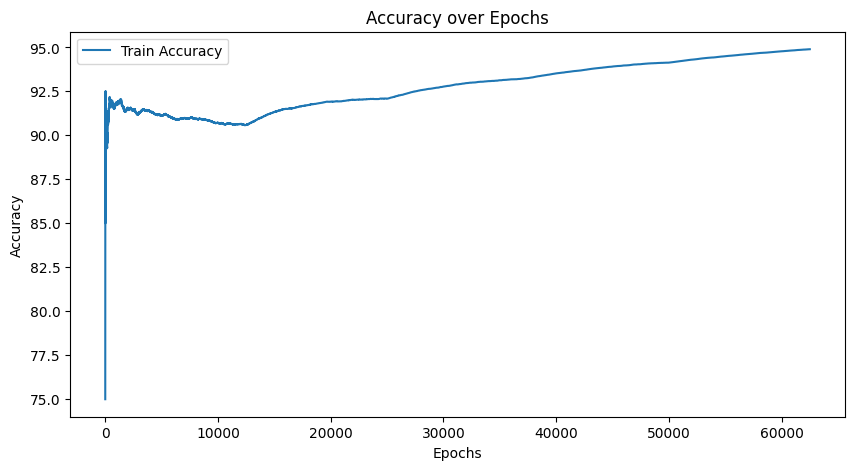

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Accuracy')
#plt.plot(test_acc_list, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(len(train_acc_list))

NameError: name 'train_acc_list' is not defined

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp